In [4]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection

from rads_extraction import convert_time

file_path = r'RADS\ASCII_files\c2_240212.asc'

warnings.filterwarnings('ignore', category=UserWarning)

In [23]:
def find_start_passes(file_path, verbose=True):
    # read the file, and determine the starting line of each pass
    with open(file_path, 'r') as f: lines = f.readlines()
    hashtag_lines = np.array([i for i, line in enumerate(lines) if '#' in line])
    diff = np.concatenate((np.array([30]), hashtag_lines[1:] - hashtag_lines[:-1]))
    start_pass_lines = hashtag_lines[diff > 1]

    if verbose:
        print(f'There are {len(start_pass_lines)} passes in ({file_path})')
    
    return start_pass_lines


def extract_pass(file_path, pass_n=None, start_pass_lines=None, plot=True, earth=Basemap(), **kwargs):
    
    if start_pass_lines is None:
        start_pass_lines = find_start_passes(file_path, verbose=False)

    if pass_n is None: # extract all passes
        skiprows = 0
        max_rows = None

        return extract_pass(file_path, np.arange(1, len(start_pass_lines)+1, 1), start_pass_lines, plot, earth, **kwargs)
    
    elif isinstance(pass_n, (list, np.ndarray)): # extract multiple passes
        assert len(set(pass_n)) == len(pass_n), 'There are repeated pass numbers!'

        secs_array = np.array([])
        lat_array = np.array([])
        lon_array = np.array([])
        sla_array = np.array([])

        cmap = plt.get_cmap('Spectral')
        colors = [cmap(i) for i in np.linspace(0, 1, len(pass_n))]
        
        for i, n in enumerate(pass_n):
            secs_i, lat_i, lon_i, sla_i = extract_pass(file_path, int(n), start_pass_lines, plot, earth, color=colors[i])

            secs_array = np.append(secs_array, secs_i)
            lat_array = np.append(lat_array, lat_i)
            lon_array = np.append(lon_array, lon_i)
            sla_array = np.append(sla_array, sla_i)
        
        return secs_array, lat_array, lon_array, sla_array

    else: # extract only one pass
        assert pass_n <= len(start_pass_lines), 'There are not that many passes in this file!'
        assert pass_n >= 1

        if pass_n == len(start_pass_lines):
            skiprows = start_pass_lines[pass_n-1]
            max_rows  = None
        else:
            skiprows = start_pass_lines[pass_n-1]
            max_rows = start_pass_lines[pass_n] - start_pass_lines[pass_n-1]

    data = np.loadtxt(file_path, skiprows=skiprows, max_rows=max_rows)

    secs_array = data[:, 0]
    lat_array  = data[:, 1]
    lon_array  = data[:, 2]
    sla_array  = data[:, 3]

    if plot:
        earth.plot(lon_array, lat_array, 'x', label=f'avg. {convert_time(np.average(secs_array))}', zorder=1, **kwargs)
        ax = plt.gca()
        ax.legend(bbox_to_anchor=(1.06, 0.99), loc='upper left')
            
    return secs_array, lat_array, lon_array, sla_array

In [21]:
def plot_intensity_line(lon_array, lat_array, val_array, earth=Basemap(), **kwargs):
    # adapted from 'https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html'
    points = np.array([lon_array, lat_array]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(np.min(val_array), np.max(val_array))
    lc = LineCollection(segments, cmap='Spectral', norm=norm)
    # Set the values used for colormapping
    ax = plt.gca()
    lc.set_array(val_array)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    earth.colorbar(line, size='2%', **kwargs)

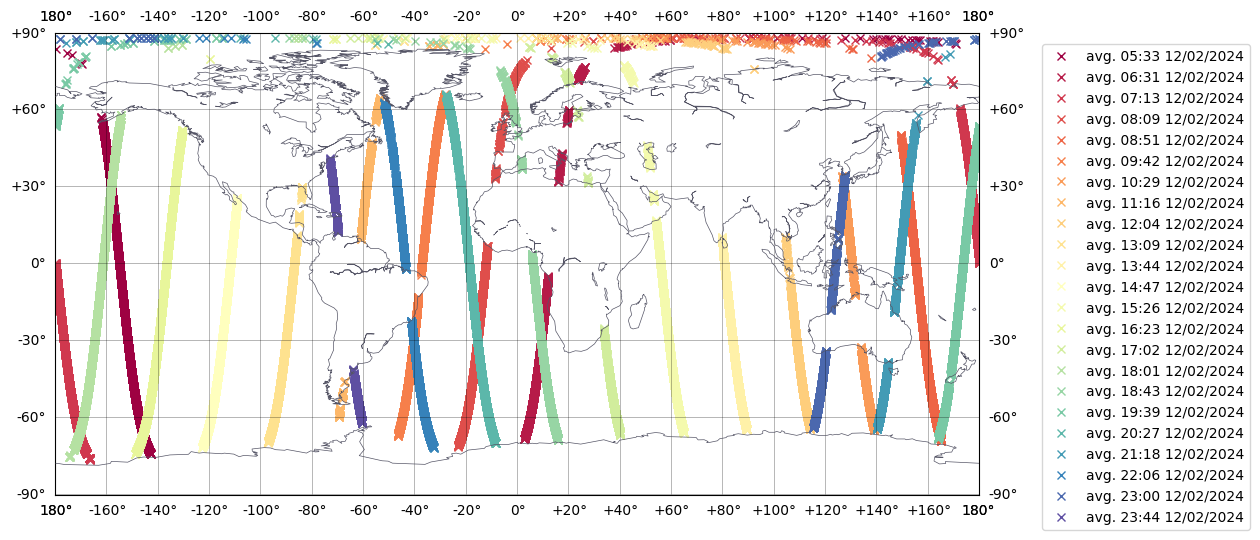

In [24]:
fig, ax = plt.subplots(figsize=(14,6))
earth=Basemap()
earth.drawcoastlines(color='#555566', linewidth=0.5, zorder=3)

cbar_pad = '8%'
grid_style = {'linewidth': 0.2, 'dashes':[1,0], 'labels':[1, 1, 1, 1], 'labelstyle':'+/-'}
earth.drawmeridians(np.arange(-180, 181, 20), **grid_style)
earth.drawparallels(np.arange(-90, 91, 30), **grid_style)

a1, b1, c1, d1 = extract_pass(file_path, earth=earth)
# 


In [2]:
import suncalc
import pandas as pd

In [15]:
lon_arr = np.arange(-180, 180, 20)
lat_arr = np.zeros(lon_arr.shape)
height_arr = np.zeros(lon_arr.shape)
day = pd.to_datetime(lon_arr.size*['2024-02-12'])

df = pd.DataFrame({'date': day, 'lat': lat_arr, 'lon': lon_arr})

lon_arr.shape, lat_arr.shape, height_arr.shape, day.shape
# ans = suncalc.get_times(day, lon_arr, lat_arr, height_arr)
suncalc.get_times(df['date'], df['lon'], df['lat'])

{'solar_noon': 0    2024-02-12 00:15:37.639010048+00:00
 1    2024-02-11 22:55:37.590533376+00:00
 2    2024-02-11 21:35:37.539562496+00:00
 3    2024-02-11 20:15:37.486137344+00:00
 4    2024-02-11 18:55:37.430177792+00:00
 5    2024-02-11 17:35:37.371803648+00:00
 6    2024-02-11 16:15:37.310895360+00:00
 7    2024-02-11 14:55:37.247532800+00:00
 8    2024-02-11 13:35:37.181675520+00:00
 9    2024-02-11 12:15:37.113363968+00:00
 10   2024-02-12 10:55:37.938188032+00:00
 11   2024-02-12 09:35:37.909425664+00:00
 12   2024-02-12 08:15:37.878209536+00:00
 13   2024-02-12 06:55:37.844538624+00:00
 14   2024-02-12 05:35:37.808373504+00:00
 15   2024-02-12 04:15:37.769754112+00:00
 16   2024-02-12 02:55:37.728680704+00:00
 17   2024-02-12 01:35:37.685072384+00:00
 dtype: datetime64[ns, UTC],
 'nadir': 0    2024-02-11 12:15:37.639010048+00:00
 1    2024-02-11 10:55:37.590533376+00:00
 2    2024-02-11 09:35:37.539562496+00:00
 3    2024-02-11 08:15:37.486137344+00:00
 4    2024-02-11 06:55:3